# Cosmology project: Measuring Cosmic acceleration with Type Ia Supernovaes

Authors: Oriol Abril Pla, Mariona Badenas Agusti

April 2018

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize as opt
import scipy.integrate as pyint
import scipy.constants as const
import scipy.stats as stat
import numpy as np
import numpy.linalg as linalg

import astropy.modeling.models as amod
import astropy.modeling.fitting as afit
import sys

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7
#rcParams['figure.figsize'] = 5.5, 3.2
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

#### Load the data
Load the sample from Union2 SNe and select only the desired coordinates.

In [2]:
database_file = 'SCPUnion2.1_AllSNe.txt'
SNe_df = pd.read_csv(database_file,header=None, sep=r'\)?\s+&\s+', engine='python', na_filter = ['\nodata','\nodata\\'],
                    names=['ID', 'z', 'mb',  'x1', 'color',
                           'd_mod', 'unknown', 'sample', 'Cuts Failed']).set_index('ID')
SNe_df['Cuts Failed'] = SNe_df['Cuts Failed'].str.slice(stop=-2)
SNe_df.info()
SNe_df = SNe_df[SNe_df['Cuts Failed']=='\\nodata']
SNe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753 entries, 1993ah to X-026
Data columns (total 8 columns):
z              753 non-null float64
mb             753 non-null object
x1             753 non-null object
color          753 non-null object
d_mod          753 non-null object
unknown        753 non-null object
sample         753 non-null float64
Cuts Failed    753 non-null object
dtypes: float64(2), object(6)
memory usage: 52.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 580 entries, 1993ah to Z-005
Data columns (total 8 columns):
z              580 non-null float64
mb             580 non-null object
x1             580 non-null object
color          580 non-null object
d_mod          580 non-null object
unknown        580 non-null object
sample         580 non-null float64
Cuts Failed    580 non-null object
dtypes: float64(2), object(6)
memory usage: 40.8+ KB


In [3]:
def split_errors(df,name):
    #print df.loc[df[name]==na][name]
    mask = df[name].str.slice(start=-6)=='nodata'
    df.loc[mask, name] = 'NaN(NaN'
    split_df = df[name].str.split('(',expand=True)
    df[name] = split_df[0].astype(float)
    df['err_{}'.format(name)] = split_df[1].astype(float)
split_errors(SNe_df,'mb')
split_errors(SNe_df,'x1')
split_errors(SNe_df,'color')
split_errors(SNe_df,'d_mod')
nice_columns = ['z', 'mb', 'err_mb',  'color', 'err_color',
                           'd_mod', 'err_d_mod', 'x1', 'err_x1']
SNe_df = SNe_df[nice_columns]
SNe_df.head()

,z,mb,err_mb,color,err_color,d_mod,err_d_mod,x1,err_x1
ID,,,,,,,,,
1993ah,0.0285,16.86,0.19,0.23,0.09,35.35,0.22,-2.26,0.93
1993ag,0.0500,17.79,0.05,0.12,0.02,36.68,0.17,-1.09,0.24
1993o,0.0529,17.60,0.05,-0.01,0.02,36.82,0.16,-1.03,0.14
1993b,0.0701,18.43,0.04,0.09,0.02,37.45,0.16,-0.53,0.21
1992bs,0.0627,18.25,0.05,0.02,0.02,37.48,0.16,-0.27,0.23


#### Load covariance matrixes

In [4]:
C_sys = np.loadtxt('SCPUnion2.1_covmat_sys.txt')
Cinv_sys = linalg.inv(C_sys)
C_nosys = np.loadtxt('SCPUnion2.1_covmat_nosys.txt')
sigma_ext2 = np.diag(C_nosys)

## Define cosmological functions

In [5]:
def chi(zvec,Hz_fun,args):
    chi = const.c/1000*np.array([pyint.quad(lambda zz: 1./Hz_fun(zz,*args),0,z)[0] for z in zvec])
    return chi

def dist_lum(z,Hz_fun,args):
    return chi(z,Hz_fun,args)*(1+z)

def dist_mod(z,Hz_fun,args):
    D_L = dist_lum(z,Hz_fun,args)
    return 5*np.log10(D_L)+25

def Hz_flatLCDM(z,Ode,H0=73.8):
    '''
    Flat Lambda-CDM model with H0 from Riess 2016 and k=0 fixed
    '''
    Om = 1-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ode)
    return Hz

def Hz_curvedLCDM(z,Om,Ode,H0=73.8):
    '''
    Curved Lambda-CDM model with H0 from Riess 2016 and k not fixed
    '''
    Ok = 1-Om-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ok*(1+z)**2+Ode)
    return Hz

def Hz_w_cte(z,Ode,w,H0=73.8):
    Om = 1-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ode*np.exp(3*(1+w)*np.log(1+z)))
    return Hz

### Plot Hubble diagram

Text(0,0.5,'Distance modulus')

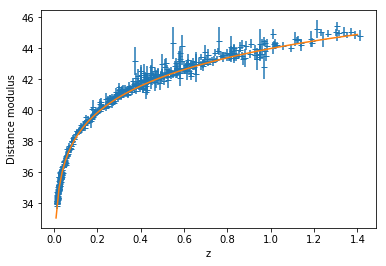

In [6]:
z_grid = np.linspace(1e-2,1.4,100)
plt.errorbar(SNe_df['z'],SNe_df['d_mod'],yerr=SNe_df['err_d_mod'],fmt='_',zorder=0)
plt.plot(z_grid,dist_mod(z_grid,Hz_flatLCDM,(0.7,)),zorder=1)
plt.xlabel('z'); plt.ylabel('Distance modulus')

#### Hubble diagram (+ zoom to linear)
Show that data does not allow propper $H_0$ calculation. The procedure to try $H_0$ calculation is to filter the SNe sample to get the low redshift subset, and make a linear fit to it. The slope will be an aproximation of $H_0$

In [7]:
# Convert z to v and d_mod to distance luminosity
v_SNe = const.c/1000.*SNe_df['z']
dL_SNe = 10**((SNe_df['d_mod']-25+2.5*np.log10(1+SNe_df['z']))/5)
# Select only low redshift/distance data
dL_max = 120
v_SNe=v_SNe[dL_SNe<dL_max]
dL_SNe=dL_SNe[dL_SNe<dL_max]
# fit both with an intercept and forcing v = H*dL
H0_fit, intercept, r, p, err = stat.linregress(dL_SNe,v_SNe)
H0_curvefit = opt.curve_fit(lambda d,H: H*d, dL_SNe, v_SNe, p0=70)[0][0]

In [8]:
age_fit = 1/H0_fit*1e6*3.86e13/3.154e7/1e9
age_curvefit = 1/H0_curvefit*1e6*3.86e13/3.154e7/1e9
print('The value of H0 forcing v(z=0)=0 is H0 = {} km/s/Mpc,\nwhich means \
an aproximate age of the universe of {} Myr'.format(H0_curvefit,age_curvefit))
print('\nThe value of H0 NOT forcing v(z=0) is H0 = {0} km/s/Mpc with v(z=0) = {1} km/s,\n\
which means an aproximate age of the universe of {2} Myr'.format(H0_fit,intercept,age_fit))

The value of H0 forcing v(z=0)=0 is H0 = 68.2734485943133 km/s/Mpc,
which means an aproximate age of the universe of 17.92560306497399 Myr

The value of H0 NOT forcing v(z=0) is H0 = 61.273112853853675 km/s/Mpc with v(z=0) = 646.8468011535952 km/s,
which means an aproximate age of the universe of 19.973568868577484 Myr


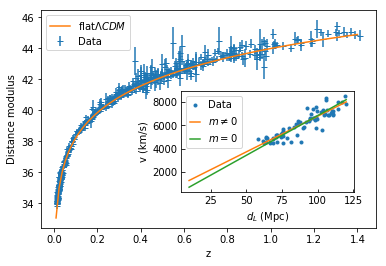

In [9]:
fig = plt.figure(); ax = fig.add_subplot(111)
ax.errorbar(SNe_df['z'],SNe_df['d_mod'],yerr=SNe_df['err_d_mod'],fmt='_',label='Data',zorder=0)
ax.plot(z_grid,dist_mod(z_grid,Hz_flatLCDM,(0.7,)),label='flat$\Lambda CDM$',zorder=1)
ax.set_xlabel('z'); ax.set_ylabel('Distance modulus')
ax.legend()

dL_grid = np.linspace(10,120)
zoom_ax = fig.add_axes([.45,.25,.4,.35])
zoom_ax.plot(dL_SNe,v_SNe,'.',label='Data')
zoom_ax.plot(dL_grid,dL_grid*H0_fit+intercept,label=r'$m\neq 0$')
zoom_ax.plot(dL_grid,dL_grid*H0_curvefit,label='$m= 0$')
zoom_ax.set_xlabel('$d_L$ (Mpc)'); zoom_ax.set_ylabel('v (km/s)')
zoom_ax.tick_params(direction='in')
zoom_ax.legend(handlelength=1)

## Find cosmological parameters 
### Flat universe and w=0
[2018-04-05] The fit is performed directly with `scipy.optimize.curve_fit`, because it already allows to weight the values with its error. However, one method of our own or from github or comething could be implemented.

[2018-04-10] The fitting is now done with `astropy.modelling`.

#### Standard fit

In [10]:
# Create astropy model
flatLCDM_aModel = amod.custom_model(lambda z,Ode=.7 : dist_mod(z,Hz_flatLCDM,(Ode,)))
 
init_flatLCDM = flatLCDM_aModel()
fit_flatLCDM = afit.LevMarLSQFitter()
flatLCDM_result = fit_flatLCDM(init_flatLCDM,
                               SNe_df['z'],
                               SNe_df['d_mod'],
                               weights=SNe_df['err_d_mod'])
flatLCDM_Ode_err = np.sqrt(np.diag(fit_flatLCDM.fit_info['param_cov']))[0]
Ode_flat = flatLCDM_result.Ode.value
Om_flat = 1-Ode_flat

In [11]:
print('The fitted values are:\n\tOm : {0:.3f}({2:.2f})\n\tOde : {1:.3f}({2:.2f})'.format(1-Ode_flat,Ode_flat,flatLCDM_Ode_err))

The fitted values are:
	Om : 0.082(0.02)
	Ode : 0.918(0.02)


In [22]:
# using equation 3.48 of the cosmology notes
q0_std = (1-Ode_flat)/2-Ode_flat
q0_error = np.sqrt(5)*flatLCDM_Ode_err/2
print('The deceleration parameter is {:.4f}({:.3g}), thus, the expansion of the universe is accelerated'.format(q0_std,q0_error))

The deceleration parameter is -0.8773(0.0205), thus, the expansion of the universe is accelerated


#### Show standard fit $\chi^2$ 
Show the obtained $\chi^2$ for the standard fit to show it is not a problem of the minimizer

In [30]:
Ode_grid = np.linspace(0,1,201)
Ode_chi_73 = [sum((SNe_df['d_mod']-dist_mod(SNe_df['z'],Hz_flatLCDM,(Ode,73.8)))**2/SNe_df['err_d_mod']) 
           for Ode in Ode_grid]
Ode_chi_69 = [sum((SNe_df['d_mod']-dist_mod(SNe_df['z'],Hz_flatLCDM,(Ode,69)))**2/SNe_df['err_d_mod']) 
           for Ode in Ode_grid]

[0.85  0.855 0.845 0.86  0.84 ]


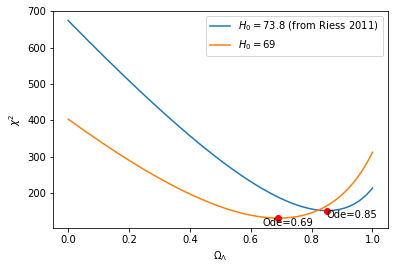

In [31]:
plt.plot(Ode_grid,Ode_chi_73,label=r'$H_0=73.8$ (from Riess 2011)')
plt.plot(Ode_grid,Ode_chi_69,label=r'$H_0=69$')
plt.xlabel(r'$\Omega_\Lambda$'); plt.ylabel(r'$\chi^2$')
plt.legend()
ind_73 = np.argmin(Ode_chi_73)
inds_73 = np.argsort(Ode_chi_73)
print(Ode_grid[inds_73[:5]])
plt.plot(Ode_grid[ind_73],Ode_chi_73[ind_73],'ro')
plt.text(Ode_grid[ind_73],Ode_chi_73[ind_73]-20,'Ode={:.2f}'.format(Ode_grid[ind_73]))
ind_69 = np.argmin(Ode_chi_69)
plt.plot(Ode_grid[ind_69],Ode_chi_69[ind_69],'ro')
plt.text(Ode_grid[ind_69]-.05,Ode_chi_69[ind_69]-20,'Ode={:.2f}'.format(Ode_grid[ind_69]))
plt.savefig('chi2_Ode.png')

#### $\chi^2$ fitting
Fit with the $\chi^2$, for some combinations of C and sigmas

In [35]:
def chi2_nosys_flatLCDM(x,data=SNe_df,sigma_ext2=sigma_ext2):
    alfa,beta,Mb,Ode = x
    Om = 1-Ode
    mu_B = data['mb']+alfa*data['x1']-beta*data['color']-Mb
    mu_cosmo = dist_mod(data['z'],Hz_flatLCDM,(Ode,))
    sigma2_lc = data['err_mb']**2+alfa**2*data['err_x1']**2+beta**2*data['err_color']**2
    return np.sum((mu_B-mu_cosmo)**2/(sigma2_lc+sigma_ext2))

def chi2_sys_flatLCDM(x,data=SNe_df,Csys=C_sys, Cext = C_nosys, Cinv_sys=Cinv_sys, mode='sys+lc'):
    alfa,beta,Mb,Ode = x
    Om = 1-Ode
    mu_B = data['mb']+alfa*data['x1']-beta*data['color']-Mb
    mu_cosmo = dist_mod(data['z'],Hz_flatLCDM,(Ode,))
    mu_diff = (mu_B-mu_cosmo)**2
    sigma2_lc = data['err_mb']**2+alfa**2*data['err_x1']**2+beta**2*data['err_color']**2
    Cinv = Cinv_sys if mode=='sys' else linalg.inv(np.diag(sigma2_lc)+Csys)
    #Cinv_2 = linalg.inv(Csys)
    #Cinv_3 = linalg.inv(np.diag(sigma2_lc)+Csys+Cext)
    res = np.matmul(mu_diff,np.matmul(Cinv,mu_diff))
    return res

In [ ]:
n_abm = 5
n_ode = 10
A = np.linspace(0,0.3,n_abm)
B = np.linspace(1.5,4,n_abm)
M = np.linspace(-19.5,-18.8,n_abm)
ODE = np.linspace(0.5,1,n_ode)
A,B,M,ODE = np.meshgrid(A,B,M,ODE)
chi2_4d_sys = np.empty_like(A)
chi2_4d_sys_lc = np.empty_like(A)
for i in range(n_abm):
    for j in range(n_abm):
        sys.stdout.flush()
        sys.stdout.write("\r{0} of {2}, {1} of {2}".format(i+1,j+1,n_abm))
        for k in range(n_abm):
            for l in range(n_ode):
                chi2_4d_sys[i,j,k,l] = chi2_sys_flatLCDM([A[i,j,k,l],
                                                          B[i,j,k,l],
                                                          M[i,j,k,l],
                                                          ODE[i,j,k,l]],mode='sys')
                chi2_4d_sys_lc[i,j,k,l] = chi2_sys_flatLCDM([A[i,j,k,l],
                                                             B[i,j,k,l],
                                                             M[i,j,k,l],
                                                             ODE[i,j,k,l]])

In [ ]:
index_sys = chi2_4d_sys.argmin()
index_sys_lc = chi2_4d_sys_lc.argmin()

index_sys = np.unravel_index(index_sys,dims=chi2_4d_sys.shape)
index_sys_lc = np.unravel_index(index_sys_lc,dims=chi2_4d_sys_lc.shape)

print(A[index_sys],B[index_sys],M[index_sys],ODE[index_sys])
print(A[index_sys_lc],B[index_sys_lc],M[index_sys_lc],ODE[index_sys_lc])

Results with finer grid (20,40): 
 - sys: 0.07894736842105263 2.263157894736842 -19.105263157894736 0.6923076923076923
 - sys+ls: 0.09473684210526316 2.473684210526316 -19.157894736842106 0.7435897435897436

In [36]:
chi2_sys_lc_res = opt.minimize(chi2_sys_flatLCDM,(0.08,2.4,-19.1,.71))

In [ ]:
Ode_sys_lc = chi2_sys_lc_res['x'][-1]
chi2_sys_lc_fixed_nuis = lambda x: chi2_sys_flatLCDM([*chi2_sys_lc_res['x'][:-1],x])-chi2_sys_lc_res['fun']-1
Ode_sys_lc_p_error = opt.fsolve(chi2_sys_lc_fixed_nuis,Ode_sys_lc+.1)[0]-Ode_sys_lc
Ode_sys_lc_m_error = Ode_sys_lc-opt.fsolve(chi2_sys_lc_fixed_nuis,Ode_sys_lc-.1)[0]

In [ ]:
Ode_chi_sys_lc = [chi2_sys_flatLCDM([*chi2_sys_lc_res['x'][:-1],Ode]) for Ode in Ode_grid]

In [ ]:
plt.plot(Ode_grid,Ode_chi_sys_lc,label='sys+lc',zorder=-1)
plt.errorbar(Ode_sys_lc,
             chi2_sys_flatLCDM([*chi2_sys_lc_res['x'][:-1],Ode_sys_lc]),
             xerr=np.array([[Ode_sys_lc_m_error],[Ode_sys_lc_p_error]]),
             fmt='+',capsize=5,zorder=1,label='Fit result (sys+lc)')
plt.plot(Ode_grid,Ode_chi_73,label=r'$H_0=73.8$ (from Riess 2011)',zorder=-1)
#plt.plot(Ode_grid,Ode_chi_69,label=r'$H_0=69$')
plt.xlabel(r'$\Omega_\Lambda$'); plt.ylabel(r'$\chi^2$')
plt.legend()

In [ ]:
print('The chi2 with nuisance parameters fit yields:\n\tOm = {0:.3g}(-{2:.2g},+{3:.2g})\n\t\
Ode = {1:.3g}(-{2:.2g},+{3:.2g})\nWith \
nuisance parameters:\n\talpha = {4:.3g}\n\tbeta = {5:.3g}\n\tM = {6:.3f}'.format(1-Ode_sys_lc,Ode_sys_lc,
                                                                  Ode_sys_lc_m_error,
                                                                  Ode_sys_lc_p_error,
                                                                  *chi2_sys_lc_res['x'][:-1]))

In [ ]:
# using equation 3.48 of the cosmology notes
q0_sys_lc = (1-Ode_sys_lc)/2-Ode_sys_lc
sigma = np.sqrt(Ode_sys_lc_m_error**2+Ode_sys_lc_p_error**2)
q0_err_sys_lc = np.sqrt(5)*sigma/2
print('The deceleration parameter is {:.3f}({:.2g}), thus, the expansion of the universe is accelerated'.format(q0_sys_lc,q0_err_sys_lc))

## Curved universe (w=0)
### Standard fit

In [ ]:
# Create astropy model
curvedLCDM_aModel = amod.custom_model(lambda z,Om=0.3,Ode=.7 : dist_mod(z,Hz_curvedLCDM,(Om,Ode)))
 
init_curvedLCDM = curvedLCDM_aModel()
fit_curvedLCDM = afit.LevMarLSQFitter()
#init_curvedLCDM.Om.bounds = [0,1.]
#init_curvedLCDM.Ode.bounds = [0,1.]
curvedLCDM_result = fit_curvedLCDM(init_curvedLCDM,
                               SNe_df['z'],
                               SNe_df['d_mod'],
                               weights=SNe_df['err_d_mod'])
print(curvedLCDM_result)
curvedLCDM_err = np.sqrt(np.diag(fit_curvedLCDM.fit_info['param_cov']))
Ode_curved = curvedLCDM_result.Ode.value
Om_curved = curvedLCDM_result.Om.value

In [ ]:
print('The fitted values are:\n\tOm  : {:.3f}({:.2f})\n\tOde : {:.3f}({:.2f})\n\tOk  : {:.3f}({:.2f})'.format(Om_curved,curvedLCDM_err[0],
                                                                                     Ode_curved,curvedLCDM_err[1],1-Om_curved-Ode_curved,
                                                                                    np.sqrt(np.sum(curvedLCDM_err**2))))

In [ ]:
# using equation 3.48 of the cosmology notes
q0_std_curved = Om_curved/2-Ode_curved
q0_err_std_curved = np.sqrt(curvedLCDM_err[0]**2/4+curvedLCDM_err[1]**2)
print('The deceleration parameter is {:.3f}({:.2g}), thus, \
the expansion of the universe is accelerated'.format(q0_std_curved,
                                                     q0_err_std_curved))

In [ ]:
Ode_grid = np.linspace(0,1,200)
Ode_chi_curved = [sum((SNe_df['d_mod']-dist_mod(SNe_df['z'],Hz_curvedLCDM,(Om_curved,Ode_curved,)))**2/SNe_df['err_d_mod']) 
           for Ode in Ode_grid]

## $\chi^2$ fitting

In [51]:
def chi2_sys_curvedLCDM(x, mode='sys+lc', data=SNe_df,Csys=C_sys, Cext = C_nosys, Cinv_sys=Cinv_sys):
    alfa,beta,Mb,Om,Ode = x
    Ok = 1-Om-Ode
    mu_B = data['mb']+alfa*data['x1']-beta*data['color']-Mb
    mu_cosmo = dist_mod(data['z'],Hz_curvedLCDM,(Om,Ode))
    mu_diff = (mu_B-mu_cosmo)**2
    sigma2_lc = data['err_mb']**2+alfa**2*data['err_x1']**2+beta**2*data['err_color']**2
    Cinv = Cinv_sys if mode=='sys' else linalg.inv(np.diag(sigma2_lc)+Csys)
    #Cinv_2 = linalg.inv(Csys)
    #Cinv_3 = linalg.inv(np.diag(sigma2_lc)+Csys+Cext)
    res = np.matmul(mu_diff,np.matmul(Cinv,mu_diff))
    return res

In [52]:
bounds = [(None,None)]*3+[(0,1)]*2
chi2_curved_sys_lc_res = opt.minimize(chi2_sys_curvedLCDM,(0.1,2.5,-19.3,.3,.7))

In [53]:
print(chi2_curved_sys_lc_res)

      fun: 51.58708193705862
 hess_inv: array([[ 1.78894338e-04, -5.95801556e-05,  5.36934074e-05,
        -1.64176164e-04, -4.06921445e-04],
       [-5.95801556e-05,  2.29630728e-03,  4.30797322e-04,
        -2.41935354e-03, -4.55190100e-03],
       [ 5.36934074e-05,  4.30797322e-04,  7.97465569e-04,
        -1.13682441e-03, -3.09122784e-03],
       [-1.64176164e-04, -2.41935354e-03, -1.13682441e-03,
         3.96677766e-03,  8.79433414e-03],
       [-4.06921445e-04, -4.55190100e-03, -3.09122784e-03,
         8.79433414e-03,  2.16148888e-02]])
      jac: array([ 3.33786011e-06,  1.38282776e-05,  9.53674316e-07,  2.14576721e-05,
       -1.52587891e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 725
      nit: 21
     njev: 102
   status: 2
  success: False
        x: array([  0.0878459 ,   2.40772469, -19.1493077 ,   0.63656536,
         1.05209751])


In [55]:
Ode_curved_sys_lc = chi2_sys_lc_res['x'][-1]
chi2_curved_sys_lc_fixed_nuis = lambda x: chi2_sys_curvedLCDM([*chi2_sys_lc_res['x'][:-1],x])-chi2_sys_lc_res['fun']-1
Ode_curved_sys_lc_p_error = opt.fsolve(chi2_sys_lc_fixed_nuis,Ode_sys_lc+.1)[0]-Ode_sys_lc
Ode_curved_sys_lc_m_error = Ode_sys_lc-opt.fsolve(chi2_sys_lc_fixed_nuis,Ode_sys_lc-.1)[0]

## Calculate $w$, the dark matter equation of state parameter
### Standard fitting

In [56]:
# Create astropy model
w_cte_aModel = amod.custom_model(lambda z,Ode=.3,w=-1 : dist_mod(z,Hz_w_cte,(Ode,w)))
 
init_w_cte = w_cte_aModel()
fit_w_cte = afit.LevMarLSQFitter()
w_cte_result = fit_w_cte(init_w_cte,
                               SNe_df['z'],
                               SNe_df['d_mod'],
                               weights=SNe_df['err_d_mod'])
w_cte_err = np.sqrt(np.diag(fit_w_cte.fit_info['param_cov']))
Om_w_cte = w_cte_result.Ode.value
Ode_w_cte = 1-Om_w_cte

In [57]:
print('The fitted values are:\n\tOde : {:.2f}({:.2f})\n\tw : {:.2f}({:.2f})'.format(Ode_w_cte,
                                                                                    w_cte_err[0],
                                                                                    w_cte_result.w.value,
                                                                                    w_cte_err[1]))

The fitted values are:
	Ode : 0.41(0.03)
	w : -4.69(1.26)


### $\chi^2$ fitting

In [58]:
def chi2_sys_wLCDM(x, mode='sys+lc', data=SNe_df,Csys=C_sys, Cext = C_nosys, Cinv_sys=Cinv_sys):
    alfa,beta,Mb,Ode,w = x
    Om = 1-Ode
    mu_B = data['mb']+alfa*data['x1']-beta*data['color']-Mb
    mu_cosmo = dist_mod(data['z'],Hz_w_cte,(Ode,w))
    mu_diff = (mu_B-mu_cosmo)**2
    sigma2_lc = data['err_mb']**2+alfa**2*data['err_x1']**2+beta**2*data['err_color']**2
    Cinv = Cinv_sys if mode=='sys' else linalg.inv(np.diag(sigma2_lc)+Csys)
    #Cinv_2 = linalg.inv(Csys)
    #Cinv_3 = linalg.inv(np.diag(sigma2_lc)+Csys+Cext)
    res = np.matmul(mu_diff,np.matmul(Cinv,mu_diff))
    return res

In [59]:
chi2_w_sys_lc_res = opt.minimize(chi2_sys_wLCDM,(0.1,2.5,-19.3,.7,-1.))

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


KeyboardInterrupt: 

In [ ]:
print(chi2_w_sys_lc_res)

#### Study the effect of Peculiar Velocities

In [32]:
import emcee
import corner

In [42]:
def chi2_sys_flatLCDM_xerr(x,sigma_vsn=300,data=SNe_df,Csys=C_sys, Cext = C_nosys, Cinv_sys=Cinv_sys):
    alfa,beta,Mb,Ode = x
    Om = 1-Ode
    mu_B = data['mb']+alfa*data['x1']-beta*data['color']-Mb
    mu_cosmo = dist_mod(data['z'],Hz_flatLCDM,(Ode,))
    mu_diff = (mu_B-mu_cosmo)**2
    sigma2_lc = data['err_mb']**2+alfa**2*data['err_x1']**2+beta**2*data['err_color']**2
    sigma2_z_bar = ((1+data['z'])/const.c)**2*sigma_vsn**2
    Cinv = linalg.inv(np.diag(sigma2_lc+sigma2_z_bar)+Csys)
    res = np.matmul(mu_diff,np.matmul(Cinv,mu_diff))
    return res

def lnprior(theta):
    if 0 < theta[3] < 1:
        return 0.0
    return -np.inf

def lnprob(theta,sigma_vsn):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + chi2_sys_flatLCDM_xerr(theta,sigma_vsn=sigma_vsn)

In [ ]:
# Physical parameters
sigma_vsn = 300.

# MCMC parameters
ndim, nwalkers = 4, 100
pos = [chi2_sys_lc_res['x'] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(sigma_vsn,))
no_pintis = sampler.run_mcmc(pos, 500)

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=[r"$\alpha$", r"$\beta$", r"$M_b$", r"$\Omega_\Lambda$"],
                      truths=chi2_sys_lc_res['x'])

$${\displaystyle \sigma_{\bar{z}}={\sqrt {\left({\frac {\partial f}{\partial z}}\right)^{2}\sigma_{z}^{2}+\left({\frac {\partial f}{\partial v_{SN}}}\right)^{2}\sigma_{v_{SN}}^{2} }}}$$


$$\frac{\partial f}{\partial z}=\frac{1}{1+\frac{v_{SN}}{c}}\sim 1$$ (if we assume that we measure $v_{SN}=0 \pm \sigma_{v_{SN}}$)

In [30]:
sigma_vsn = 300.
sigma_z_obs = 0. #the union2.1 measurements assume that sigma_z_obs =
d_mod = SNe_df['d_mod']
z_obs = SNe_df['z'] #we assume that z_obs is equivalent to \bar{z} 
# since we take v_sn to be 0 with an uncertainty sigma_v_sn = 300
z_bar = z_obs

d_mod_err = SNe_df['err_d_mod']

N = len(z_obs) 
v_SN = np.random.normal(loc=0, scale=300, size=N) 

sigma_z_bar = np.sqrt(sigma_z_obs**2+((1+z_obs)/const.c)**2*sigma_vsn**2)
print(sigma_z_bar[0])

1.0292120157338982


In [31]:
from scipy.odr import ODR, Model, Data, RealData

data = RealData(z_bar, d_mod, sx=sigma_z_bar, sy=d_mod_err)
model = Model(lambda Ode,z : dist_mod(z,Hz_flatLCDM,(Ode,)))

odr = ODR(data, model, [.7])
odr.set_job(fit_type=0)
output = odr.run()
print(output.beta)
print(output.sd_beta)

[0.90044111]
[0.01023974]


From Davis et al. 2011:

$$
(1+z)=(1+\bar{z})(1-v_\odot/c + v_{SN}/c)
$$

where $z$ is the observed redsfhit, and $\bar{z}$ is the cosmological redshift. 

Reference values: $v_\odot$ = 371km/s, $\sigma_{SN}$ = 300km/s).

## Questions

* How to fit? Is curve_fit enough?
* Do we have to explore models different than flat Universe?
* In the study of peculiar velocities, we're assuming that the distance modulus remains unchanged after incorporating vsn and Vsun. however, the distance modulus depends on the luminosity distance, which according to Davis et al. (2011), should also be corrected for peculiar velocities. The results presented in this notebook assume $\mu$ is unchanged.


Last question: It's possible to do it theoretically as an order of magnitude.

# Determination of $H_0$
